In [1]:
#!pip install -r requirements.txt
import torch
from IMV_LSTM.networks import IMVTensorMultiStepLSTM
from IMV_LSTM.model_prep import prepare_multistep_data
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from models.PatchTST_Attention import Model
from data_provider.data_loader import Dataset_Custom
from evaluation.performance import stepwise_errors, get_preds_truths, evaluate
from evaluation.randomize_patchtst import (
    restore_original_attention,
    enable_attention_randomization,
    disable_attention_randomization,
    patchtst_randomization_check
)
from evaluation.randomize_imv_lstm import imvlstm_attention_randomization_check
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os, re
from evaluation.randomize_imv_lstm import imvlstm_beta_randomization_check
from evaluation.attention_plots import plot_imv_saved_attention
from evaluation.attention_plots import plot_patchtst_temporal


In [2]:
df=pd.read_csv("./dataset/weather_int.csv")

In [3]:
df.describe()

,p (mbar),Tdew (degC),sh (g/kg),wv (m/s),max. wv (m/s),wd (deg),T (degC)
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,5.409105,6.111159,1.995935,3.632807,176.850276,10.818241
std,9.207149,5.956722,2.561536,43.596931,2.462467,81.194840,7.468671
min,955.580000,-13.810000,1.300000,-9999.000000,0.000000,0.000000,-6.440000
25%,984.800000,0.777500,4.070000,1.000000,1.770000,141.100000,4.590000
50%,990.920000,5.260000,5.610000,1.770000,3.000000,195.500000,10.230000
75%,995.930000,9.700000,7.620000,2.920000,4.850000,226.700000,16.180000
max,1020.070000,20.500000,15.400000,13.770000,22.900000,360.000000,34.800000


# Model Training

## PatchTST

In [4]:
#%run scripts/PatchTST/weather_int.py


In [5]:
#%run scripts/PatchTST/weather_int.py

## IMV LSTM

In [6]:
#%run scripts/IMV_LSTM/weather_int_IMV_LSTM.py \
#  --root_path C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/ \
#  --data_path weather_int.csv \
#  --input_window 576 \
#  --forecast_horizon 144 \
#  --batch_size 128 \
 # --epochs 100 \
#  --lr 3e-4 \
#  --patience 25 \
#  --save_dir ./logs/IMV_weather


# Model Evaluation

## Loading Models from Path

### Prediction Length 10 - PatchTST

In [7]:
class Args_small:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 144
    label_len = 10
    pred_len = 10

    # PatchTST
    fc_dropout = 0.1
    head_dropout = 0.0
    patch_len = 12
    stride = 6
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.1
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0001
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_small = Args_small()



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path=(
    "checkpoints/"
    "weather_int_144_10_PatchTST"
    "/checkpoint.pth"
)
ckpt_patch = torch.load(ckpt_path, map_location=device)

state_dict_patch = ckpt_patch.get("model_state_dict", ckpt_patch)
model_patch = Model(args_small)
model_patch = model_patch.float().to(device)
model_patch.load_state_dict(state_dict_patch)
model_patch.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 6))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=140, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
   

In [9]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_test = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "test",                 # pulls the test split
    size        = [144, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch = DataLoader(
    dataset_test,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


In [10]:
class Args_small_shared:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 144
    label_len = 10
    pred_len = 10

    # PatchTST
    fc_dropout = 0.1
    head_dropout = 0.0
    patch_len = 12
    stride = 6
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 0  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.1
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0001
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_small_shared = Args_small_shared()
ckpt_path_shared=(
    "checkpoints/"
    "weather_int_144_10_PatchTST_shared"
    "/checkpoint_new.pth"
)
ckpt_patch_shared = torch.load(ckpt_path_shared, map_location=device)

state_dict_patch_shared = ckpt_patch_shared.get("model_state_dict", ckpt_patch_shared)
model_patch_shared = Model(args_small_shared)
model_patch_shared = model_patch_shared.float().to(device)
model_patch_shared.load_state_dict(state_dict_patch_shared)
model_patch_shared.eval()



Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 6))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=140, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
   

### Prediction Length 10 - IMV-LSTM

In [11]:
# 1) Re-create the model with the same hyper-parameters:
model_IMV = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 10
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV = "./IMV_weather_144_10/attention_val/checkpoint_latest.pth"
state_IMV = torch.load(ckpt_path_IMV, map_location=device)
model_IMV.load_state_dict(state_IMV['model_state'])

df = pd.read_csv("dataset/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window = 144  # instead of 40
forecast_horizon = 10
batch_size_weather=128
X_train_multi, y_train_multi, \
X_val_multi, y_val_multi, \
X_test_multi, y_test_multi, \
input_scaler_multi, target_scaler_multi = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window,
    forecast_horizon=forecast_horizon,
    scale_data=True
)
X_train_t_multi = torch.tensor(X_train_multi, dtype=torch.float32)
X_val_t_multi   = torch.tensor(X_val_multi, dtype=torch.float32)
X_test_t_multi  = torch.tensor(X_test_multi, dtype=torch.float32)

y_train_t_multi = torch.tensor(y_train_multi, dtype=torch.float32)
y_val_t_multi   = torch.tensor(y_val_multi, dtype=torch.float32)
y_test_t_multi  = torch.tensor(y_test_multi, dtype=torch.float32)


test_loader_IMV = DataLoader(
    TensorDataset(X_test_t_multi, y_test_t_multi),
    shuffle=False,
    batch_size=batch_size_weather
)

### Prediction Length 72 - PatchTST

In [12]:
class Args_mid:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 432
    label_len = 72
    pred_len = 72

    # PatchTST
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 24
    stride = 12
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0003
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_mid = Args_mid()



In [13]:
import os
import torch

# 1) Set device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_dir_mid  = (
    "checkpoints/"
    "weather_int_432_72_PatchTST"
)
ckpt_path_mid = os.path.join(ckpt_dir_mid, "checkpoint.pth")  # or checkpoint_latest.pth

# sanity check
assert os.path.isfile(ckpt_path_mid), f"Checkpoint not found: {ckpt_path_mid}"

# 2) Load the checkpoint
ckpt_mid = torch.load(ckpt_path_mid, map_location=device)

# 3) Extract the state dict (fallback to the whole object if it isn’t a dict)
state_dict_patch_mid = ckpt_mid.get("model_state", ckpt_mid)

# 4) Rebuild & load your model
model_patch_mid = Model(args_mid).to(device).float()
model_patch_mid.load_state_dict(state_dict_patch_mid)
model_patch_mid.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=24, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [14]:
class Args_mid_shared:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 432
    label_len = 72
    pred_len = 72

    # PatchTST
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 24
    stride = 12
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 0  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_in = 7  # which is 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0003
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_mid_shared = Args_mid_shared()


# 1) Set device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_dir_mid_shared  = (
    "checkpoints/"
    "weather_int_432_72_PatchTST_shared"
)
ckpt_path_mid_shared = os.path.join(ckpt_dir_mid_shared, "checkpoint_new.pth")  # or checkpoint_latest.pth

# sanity check
assert os.path.isfile(ckpt_path_mid_shared), f"Checkpoint not found: {ckpt_path_mid_shared}"

# 2) Load the checkpoint
ckpt_mid_shared = torch.load(ckpt_path_mid_shared, map_location=device)

# 3) Extract the state dict (fallback to the whole object if it isn’t a dict)
state_dict_patch_mid_shared = ckpt_mid_shared.get("model_state", ckpt_mid_shared)

# 4) Rebuild & load your model
model_patch_mid_shared = Model(args_mid_shared).to(device).float()
model_patch_mid_shared.load_state_dict(state_dict_patch_mid_shared, strict=False)
model_patch_mid_shared.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=24, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [15]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_test_patch_mid = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "test",                 # pulls the test split
    size        = [432, 72, 72],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch_mid = DataLoader(
    dataset_test_patch_mid,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


### Prediction Length 72 - IMV-LSTM 

In [16]:
# 1) Re-create the model with the same hyper-parameters:
model_IMV_mid = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 72
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV_mid = "./IMV_weather_432_72/attention_val/checkpoint_latest.pth"
state_IMV_mid = torch.load(ckpt_path_IMV_mid, map_location=device)
model_IMV_mid.load_state_dict(state_IMV_mid['model_state'])

df = pd.read_csv("dataset/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window_mid = 432   # instead of 40
forecast_horizon_mid = 72
batch_size_weather=128
X_train_mid, y_train_mid, \
X_val_mid, y_val_mid, \
X_test_mid, y_test_mid, \
input_scaler_mid, target_scaler_mid = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window_mid,
    forecast_horizon=forecast_horizon_mid,
    scale_data=True
)
X_train_t_mid = torch.tensor(X_train_mid, dtype=torch.float32)
X_val_t_mid   = torch.tensor(X_val_mid, dtype=torch.float32)
X_test_t_mid  = torch.tensor(X_test_mid, dtype=torch.float32)

y_train_t_mid = torch.tensor(y_train_mid, dtype=torch.float32)
y_val_t_mid   = torch.tensor(y_val_mid, dtype=torch.float32)
y_test_t_mid  = torch.tensor(y_test_mid, dtype=torch.float32)


test_loader_IMV_mid = DataLoader(
    TensorDataset(X_test_t_mid, y_test_t_mid),
    shuffle=False,
    batch_size=batch_size_weather,
    num_workers = 0
)

### Prediction Length 144 - PatchTST

In [17]:
class Args_long:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'weather_int'
    model = 'PatchTST_Attention'

    # data loader
    data = 'custom'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 576     # 4 days of history (576 × 10 min)
    label_len = 72   # decoder sees last 1 day (144 steps)
    pred_len = 144    # forecast horizon = 1 day

    # PatchTST-specific
    fc_dropout = 0.3
    head_dropout = 0.0
    patch_len = 48   # 4 h patches (24 × 10 min)
    stride = 24       # 50% overlap
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Transformer backbone
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 560
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 25
    learning_rate = 1e-4
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.5
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0'
    test_flop = False

args_long = Args_long()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path_long=(
    "checkpoints/"
    "weather_int_576_144_PatchTST"
    "/checkpoint.pth"
)

ckpt_patch_long = torch.load(ckpt_path_long, map_location=device)

state_dict_patch_long = ckpt_patch_long.get("model_state_dict", ckpt_patch_long)
model_patch_long = Model(args_long)
model_patch_long = model_patch_long.float().to(device)
model_patch_long.load_state_dict(state_dict_patch_long)
model_patch_long.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 24))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=48, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [18]:
class Args_long_shared:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'weather_int'
    model = 'PatchTST_Attention'

    # data loader
    data = 'custom'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 576     # 4 days of history (576 × 10 min)
    label_len = 72   # decoder sees last 1 day (144 steps)
    pred_len = 144    # forecast horizon = 1 day

    # PatchTST-specific
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 48    # 4 h patches (24 × 10 min)
    stride = 24       # 50% overlap
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 0  # True

    # Transformer backbone
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 560
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 25
    learning_rate = 1e-4
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0'
    test_flop = False

args_long_shared = Args_long_shared()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path_long_shared=(
    "checkpoints/"
    "weather_int_576_144_PatchTST_shared"
    "/checkpoint_new.pth"
)

ckpt_patch_long_shared = torch.load(ckpt_path_long_shared, map_location=device)

state_dict_patch_long_shared = ckpt_patch_long_shared.get("model_state_dict", ckpt_patch_long_shared)
model_patch_long_shared = Model(args_long_shared)
model_patch_long_shared = model_patch_long_shared.float().to(device)
model_patch_long_shared.load_state_dict(state_dict_patch_long_shared)
model_patch_long_shared.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 24))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=48, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [19]:
# 1) Instantiate your long-horizon test dataset exactly as during training
dataset_test_patch_long = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "test",               # pulls the test split
    size        = [576, 72, 144],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch_long = DataLoader(
    dataset_test_patch_long,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


### Prediction Length 144 - IMV-LSTM

In [20]:
# 1) Re-create your long-horizon IMV‐LSTM model
model_IMV_long = IMVTensorMultiStepLSTM(
    input_dim      = 7,
    output_dim     = 1,
    n_units        = 140,
    forecast_steps = 144        # forecast_horizon_long
).float().to(device)

# 2) Load the long-horizon checkpoint
ckpt_path_IMV_long = "./IMV_weather_576_144/attention_val/checkpoint_latest.pth"
state_IMV_long= torch.load(ckpt_path_IMV_long, map_location=device)
model_IMV_long.load_state_dict(state_IMV_long['model_state'])

# 3) Prepare your data for the long run
df = pd.read_csv("dataset/weather_int.csv")
target_weather      = 'T (degC)'
cols_weather_multi  = [
    'p (mbar)', 'Tdew (degC)', 'sh (g/kg)',
    'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'T (degC)'
]
input_window_long     = 576   # e.g. 4 days of history (576×10 min)
forecast_horizon_long = 144   # 1 day ahead (144×10 min)
batch_size_weather    = 128

X_train_long, y_train_long, \
X_val_long,   y_val_long,   \
X_test_long,  y_test_long,  \
in_scaler_long, out_scaler_long = prepare_multistep_data(
    df=df,
    input_columns = cols_weather_multi,
    target_column = target_weather,
    input_window  = input_window_long,
    forecast_horizon = forecast_horizon_long,
    scale_data    = True
)

# 4) Tensor‐ify
X_test_t_long = torch.tensor(X_test_long, dtype=torch.float32)
y_test_t_long = torch.tensor(y_test_long, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
test_loader_IMV_long = DataLoader(
    TensorDataset(X_test_t_long, y_test_t_long),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)


### Scaler

In [21]:
# Extract only the target column (same as in your dataset)
df = pd.read_csv("dataset/weather_int.csv")
target = 'T (degC)'
data = df[[target]].values

# Match train split logic (70% of total rows)
num_train = int(len(data) * 0.7)
train_data = data[:num_train]

# Recreate and fit the scaler
scaler = StandardScaler()
scaler.fit(train_data)


StandardScaler()

## Timeshap

### train loaders

In [22]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_train_patch_short = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "train",                 # pulls the test split
    size        = [144, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_short = DataLoader(
    dataset_train_patch_short,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


In [23]:
# 1) Instantiate your long-horizon test dataset exactly as during training
dataset_train_patch_long = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "train",               # pulls the test split
    size        = [576, 72, 144],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_long = DataLoader(
    dataset_train_patch_long,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


In [24]:
dataset_train_patch_mid = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "train",               # pulls the test split
    size        = [432, 72, 72],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_mid = DataLoader(
    dataset_train_patch_mid,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)

In [25]:
##long
# 4) Tensor‐ify
X_train_t_long = torch.tensor(X_train_long, dtype=torch.float32)
y_train_t_long = torch.tensor(y_train_long, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_long = DataLoader(
    TensorDataset(X_train_t_long, y_train_t_long),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)
##mid
# 4) Tensor‐ify
X_train_t_mid = torch.tensor(X_train_mid, dtype=torch.float32)
y_train_t_mid = torch.tensor(y_train_mid, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_mid = DataLoader(
    TensorDataset(X_train_t_mid, y_train_t_mid),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)
# 4) Tensor‐ify
X_train_t_short = torch.tensor(X_train_multi, dtype=torch.float32)
y_train_t_short = torch.tensor(y_train_multi, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_short = DataLoader(
    TensorDataset(X_train_t_short, y_train_t_short),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)

In [26]:
dataset_test_IMV_mid=TensorDataset(X_test_t_mid, y_test_t_mid)
dataset_test_IMV_long=TensorDataset(X_test_t_long, y_test_t_long)
dataset_test_IMV_short=TensorDataset(X_test_t_multi, y_test_t_multi)

## Grid Search Params

In [27]:
'''import itertools
import pandas as pd
import evaluation.timeshap as tshap
importlib.reload(tshap) 
from evaluation.timeshap import explain_with_chunks

# 1) define your grid
tolerances     = [0.01, 0.05, 0.1, 0.2]
noise_vars     = [0.1, 1.0, 10.0]
nsamples_kshap = 50

# 2) SHAP hyper‐params (we’ll reuse these for all three levels)
pruning_kwargs = {"tol": None, "nsamples": nsamples_kshap}  # we'll fill "tol" in the loop
event_kwargs   = {"nsamples": nsamples_kshap, "noise_variance": None}
feature_kwargs = {"nsamples": nsamples_kshap}

# 3) storage
records = []

# 4) loop through tol × noise
for tol, noise in itertools.product(tolerances, noise_vars):
    run_name = f"tol{tol}_noise{noise}"
    print(f"\n>> PatchTST chunked explanation with tol={tol}, noise={noise} …")

    # inject this round’s tol & noise
    pruning_kwargs["tol"]          = tol
    event_kwargs["noise_variance"] = noise

    # run chunked explanation
    out_chunks = explain_with_chunks(
        model           = model_patch,
        train_loader    = train_loader_patch_short,
        test_dataset    = dataset_test,
        seq_len         = 144,
        feature_names   = cols_weather_multi,
        chunk_thresh    = 40,
        out_prefix      = f"patch_short_{run_name}",

        pruning_kwargs  = pruning_kwargs,
        event_kwargs    = event_kwargs,
        feature_kwargs  = feature_kwargs,
        device          = device,
    )

    # collect diagnostics across *all* chunks
    n_kept_per_chunk    = [info["pruning"][1] for info in out_chunks.values()]
    total_kept_events   = sum(n_kept_per_chunk)

    # also sum up total |Shapley| from event‐level across chunks
    total_abs_shap = 0.0
    for info in out_chunks.values():
        ev = info["event"]
        total_abs_shap += ev["Shapley Value"].abs().sum()

    records.append({
        "tol":            tol,
        "noise_variance": noise,
        "n_kept_events":  total_kept_events,
        "total_abs_shap": total_abs_shap,
    })

# 5) assemble into a DataFrame
df = pd.DataFrame(records)
print(df)

# 6) pivot & plot
pivot = df.pivot(index="tol", columns="noise_variance", values="n_kept_events")
print(pivot)
pivot.plot(kind="bar", figsize=(6,4),
           title="# events kept (summed) by tol & noise_variance for PatchTST")
'''

'import itertools\nimport pandas as pd\nimport evaluation.timeshap as tshap\nimportlib.reload(tshap) \nfrom evaluation.timeshap import explain_with_chunks\n\n# 1) define your grid\ntolerances     = [0.01, 0.05, 0.1, 0.2]\nnoise_vars     = [0.1, 1.0, 10.0]\nnsamples_kshap = 50\n\n# 2) SHAP hyper‐params (we’ll reuse these for all three levels)\npruning_kwargs = {"tol": None, "nsamples": nsamples_kshap}  # we\'ll fill "tol" in the loop\nevent_kwargs   = {"nsamples": nsamples_kshap, "noise_variance": None}\nfeature_kwargs = {"nsamples": nsamples_kshap}\n\n# 3) storage\nrecords = []\n\n# 4) loop through tol × noise\nfor tol, noise in itertools.product(tolerances, noise_vars):\n    run_name = f"tol{tol}_noise{noise}"\n    print(f"\n>> PatchTST chunked explanation with tol={tol}, noise={noise} …")\n\n    # inject this round’s tol & noise\n    pruning_kwargs["tol"]          = tol\n    event_kwargs["noise_variance"] = noise\n\n    # run chunked explanation\n    out_chunks = explain_with_chunks(

## IMV 

In [28]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)
from evaluation.timeshap import explain_with_chunks

# ─── 1) Define your IMV-short experiment ────────────────────────────────────
experiments_IMV_1 = [
    {
        "model":           model_IMV,
        "train_loader":    train_loader_IMV_short,
        "test_dataset":    dataset_test_IMV_short,
        "seq_len":         144,
        "out_prefix":      "IMV_short",
    },
]

# ─── 2) Set your SHAP grid (or single choice) ───────────────────────────────
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50,  "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run explanations ─────────────────────────────────────────────────────
results_IMV_1 = {}
for exp in experiments_IMV_1:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_IMV_1[exp['out_prefix']] = explain_with_chunks(
        # core args
        model         = exp["model"],
        train_loader  = exp["train_loader"],
        test_dataset  = exp["test_dataset"],
        seq_len       = exp["seq_len"],

        # human-readable feature names
        feature_names = cols_weather_multi,

        # how to chunk the 144-step sequence
        chunk_thresh  = 20,
        out_prefix    = exp["out_prefix"],

        # temporal-coalition pruning
        pruning_kwargs = pruning_kwargs,

        # event-level SHAP
        event_kwargs   = event_kwargs,

        # feature-level SHAP
        feature_kwargs = feature_kwargs,

        # device (defaults to CUDA if available)
        device         = device,
    )


>>> Explaining IMV_short …
>>> Explaining chunk 1/8: [0:20] …
>>> Explaining chunk 2/8: [20:40] …
Unable to prune sequence.
>>> Explaining chunk 3/8: [40:60] …
Unable to prune sequence.
>>> Explaining chunk 4/8: [60:80] …
Unable to prune sequence.
>>> Explaining chunk 5/8: [80:100] …
Unable to prune sequence.
>>> Explaining chunk 6/8: [100:120] …
>>> Explaining chunk 7/8: [120:140] …
>>> Explaining chunk 8/8: [140:144] …


In [ ]:

# ── USAGE ─────────────────────────────────────────────────────────
#export_full_pruning_shap(
 #   results_IMV_1["IMV_short"],
  #  seq_len      = 144,
   # chunk_thresh = 20,
    #out_path     = "IMV_short_full_pruning_shap.npy"
#)


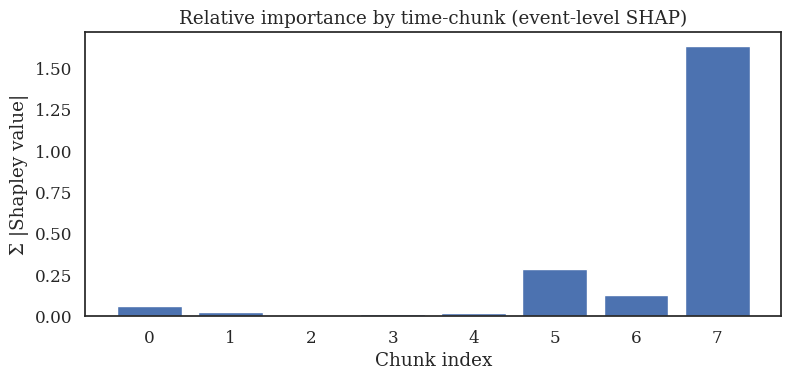

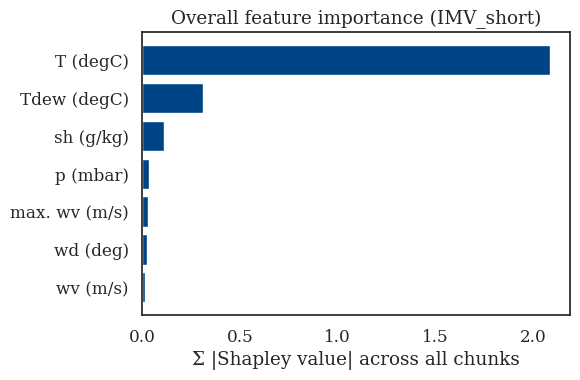

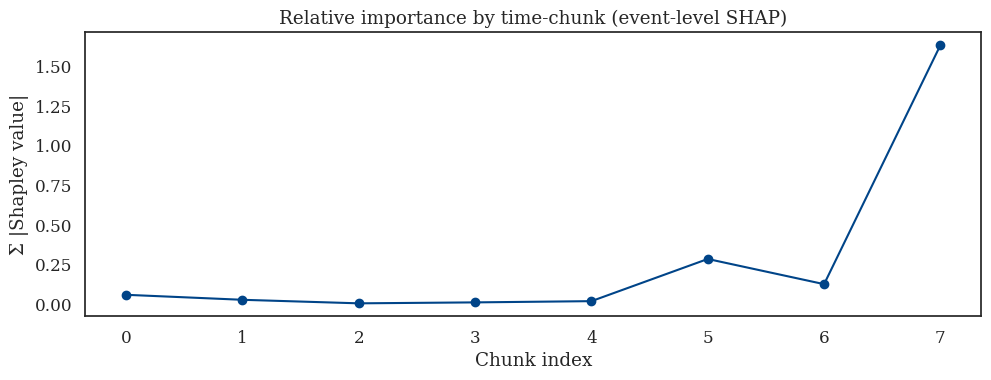

In [38]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)
from evaluation.timeshap import explain_model_window, explain_with_chunks, plot_chunk_importance_by_events,plot_aggregated_feature_importance,plot_chunk_importance_by_events_line
# 1) Plot which time-chunks mattered most:
plot_chunk_importance_by_events(results_IMV_1, top_key="IMV_short")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_IMV_2, top_key="IMV_mid", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="IMV_weather_144_10/attention_test",results=results_IMV_1, top_key="IMV_short", feature_names=cols_weather_multi)
plot_chunk_importance_by_events_line(attn_dir="IMV_weather_144_10/attention_test",results=results_IMV_1, top_key="IMV_short")

In [39]:

# ─── 1) Define your long-horizon IMV experiment ────────────────────────────
experiments_IMV_2 = [
    {
        "model":           model_IMV_mid,
        "train_loader":    train_loader_IMV_mid,
        "test_dataset":    dataset_test_IMV_mid,
        "seq_len":         432,
        "out_prefix":      "IMV_mid",
    },
]

# ─── 2) SHAP hyper-parameters ───────────────────────────────────────────────
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

results_IMV_2 = {}
for exp in experiments_IMV_2:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_IMV_2[exp['out_prefix']] = explain_with_chunks(
        # core args
        model         = exp["model"],
        train_loader  = exp["train_loader"],
        test_dataset  = exp["test_dataset"],
        seq_len       = exp["seq_len"],

        # human‐readable feature names
        feature_names = cols_weather_multi,

        # how to chunk
        chunk_thresh  = 20,
        out_prefix    = exp["out_prefix"],

        # pruning hyper‐params
        pruning_kwargs = {
            "tol":      0.05,   # keep 90% of total attribution
            "nsamples": 50,   # kernel‐SHAP samples
        },

        # event‐level hyper‐params
        event_kwargs = {
            "nsamples":       50,
            "noise_variance": 0.1,
        },

        # feature‐level hyper‐params
        feature_kwargs = {
            "nsamples": 50
        }
    )



>>> Explaining IMV_mid …
>>> Explaining chunk 1/22: [0:20] …
>>> Explaining chunk 2/22: [20:40] …
>>> Explaining chunk 3/22: [40:60] …
>>> Explaining chunk 4/22: [60:80] …
>>> Explaining chunk 5/22: [80:100] …
>>> Explaining chunk 6/22: [100:120] …
Unable to prune sequence.
>>> Explaining chunk 7/22: [120:140] …
>>> Explaining chunk 8/22: [140:160] …
Unable to prune sequence.
>>> Explaining chunk 9/22: [160:180] …
>>> Explaining chunk 10/22: [180:200] …
>>> Explaining chunk 11/22: [200:220] …
>>> Explaining chunk 12/22: [220:240] …
>>> Explaining chunk 13/22: [240:260] …
>>> Explaining chunk 14/22: [260:280] …
>>> Explaining chunk 15/22: [280:300] …
>>> Explaining chunk 16/22: [300:320] …
>>> Explaining chunk 17/22: [320:340] …
>>> Explaining chunk 18/22: [340:360] …
>>> Explaining chunk 19/22: [360:380] …
Unable to prune sequence.
>>> Explaining chunk 20/22: [380:400] …
Unable to prune sequence.
>>> Explaining chunk 21/22: [400:420] …
>>> Explaining chunk 22/22: [420:432] …
Unable to 

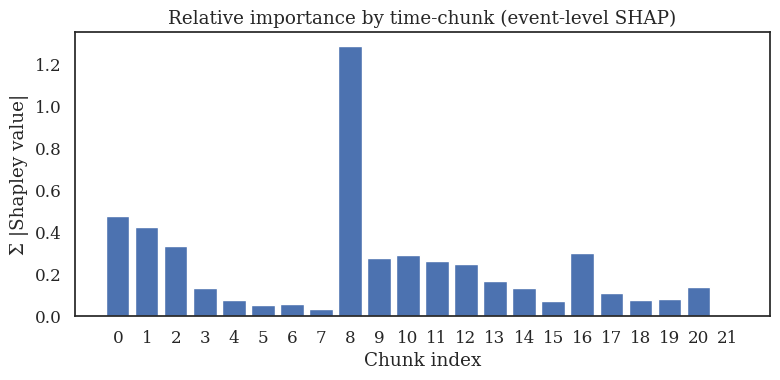

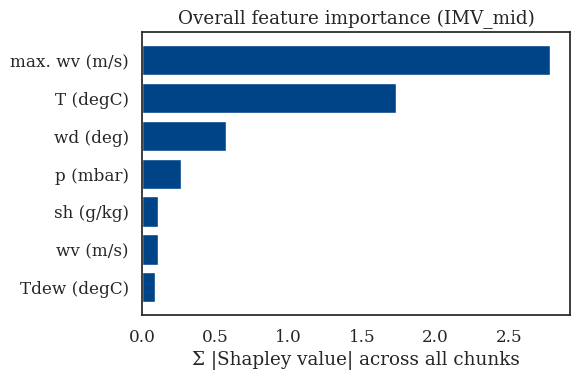

In [42]:
# 1) Plot which time-chunks mattered most:
plot_chunk_importance_by_events(results=results_IMV_2, top_key="IMV_mid")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_IMV_2, top_key="IMV_mid", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="IMV_weather_432_72/attention_test",results=results_IMV_2, top_key="IMV_mid")


In [ ]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)
from evaluation.timeshap import explain_with_chunks

# ─── 1) Define your long-horizon IMV experiment ────────────────────────────
experiments_IMV_3 = [
    {
        "model":           model_IMV_long,
        "train_loader":    train_loader_IMV_long,
        "test_dataset":    dataset_test_IMV_long,
        "seq_len":         576,
        "out_prefix":      "IMV_long",
    },
]

# ─── 2) SHAP hyper-parameters ───────────────────────────────────────────────
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run explanations ────────────────────────────────────────────────────
results_IMV_3 = {}
for exp in experiments_IMV_3:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_IMV_3[exp['out_prefix']] = explain_with_chunks(
        # core args
        model         = exp["model"],
        train_loader  = exp["train_loader"],
        test_dataset  = exp["test_dataset"],
        seq_len       = exp["seq_len"],

        # human-readable feature names
        feature_names = cols_weather_multi,

        # chunk size & output folder
        chunk_thresh   = 20,
        out_prefix     = exp["out_prefix"],

        # pruning-level SHAP
        pruning_kwargs = pruning_kwargs,

        # event-level SHAP
        event_kwargs   = event_kwargs,

        # feature-level SHAP
        feature_kwargs = feature_kwargs,

        # device (optional, defaults to cuda if available)
        device         = device
    )


In [ ]:
#export_full_pruning_shap(
#    results_IMV_3["IMV_long"],
#    seq_len      = 576,
#    chunk_thresh = 20,
#    out_path     = "IMV_long_full_pruning_shap.npy"
#)


In [ ]:


#plot_chunk_importance(results_IMV_3, top_key="IMV_long")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_IMV_3, top_key="IMV_long", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="IMV_weather_576_144/attention_test",results=results_IMV_3, top_key="IMV_long")
plot_chunk_importance_by_events_line(attn_dir="IMV_weather_576_144/attention_test",results=results_IMV_3, top_key="IMV_long")

In [30]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)  
from evaluation.timeshap import explain_with_chunks

# ─── 1) Experiment definition ────────────────────────────────────────────────
experiments_patch_short = [
    {
        "model":           model_patch,
        "train_loader":    train_loader_patch_short,
        "test_dataset":    dataset_test,
        "seq_len":         144,
        "out_prefix":      "patch_short",
    },
]

# ─── 2) Grid you want to try (for example) ──────────────────────────────────
# You can loop over any combination of tol / noise if you like,
# but here’s the simplest: one run with default hyper‐params.
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run `explain_with_chunks` on your patch_short model ────────────────
results_patch_short = {}
for exp in experiments_patch_short:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_patch_short[exp['out_prefix']] = explain_with_chunks(
        # core args
        model        = exp["model"],
        train_loader = exp["train_loader"],
        test_dataset = exp["test_dataset"],
        seq_len      = exp["seq_len"],

        # human‐readable feature names
        feature_names = cols_weather_multi,

        # chunking & I/O
        chunk_thresh   = 20,
        out_prefix     = exp["out_prefix"],

        # pruning‐level SHAP
        pruning_kwargs = pruning_kwargs,

        # event‐level SHAP
        event_kwargs   = event_kwargs,

        # feature‐level SHAP
        feature_kwargs = feature_kwargs,

        # device (optional, defaults to cuda if available)
        device         = device
    )


>>> Explaining patch_short …
>>> Explaining chunk 1/8: [0:20] …
Unable to prune sequence.
>>> Explaining chunk 2/8: [20:40] …
Unable to prune sequence.
>>> Explaining chunk 3/8: [40:60] …
Unable to prune sequence.
>>> Explaining chunk 4/8: [60:80] …
Unable to prune sequence.
>>> Explaining chunk 5/8: [80:100] …
Unable to prune sequence.
>>> Explaining chunk 6/8: [100:120] …
>>> Explaining chunk 7/8: [120:140] …
>>> Explaining chunk 8/8: [140:144] …


In [ ]:
#export_full_pruning_shap(
 #   results_patch_short["patch_short"],
  #  seq_len      = 144,
   # chunk_thresh = 20,
    #out_path     = "patch_short_full_pruning_shap.npy")

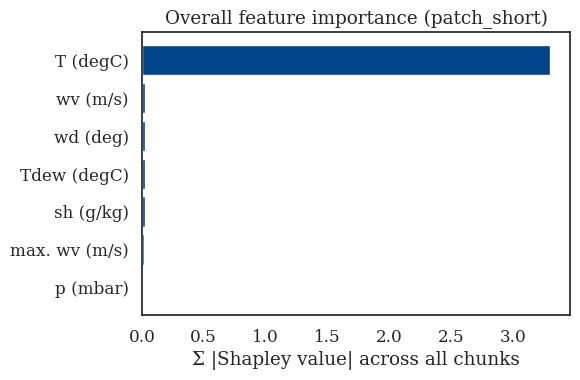

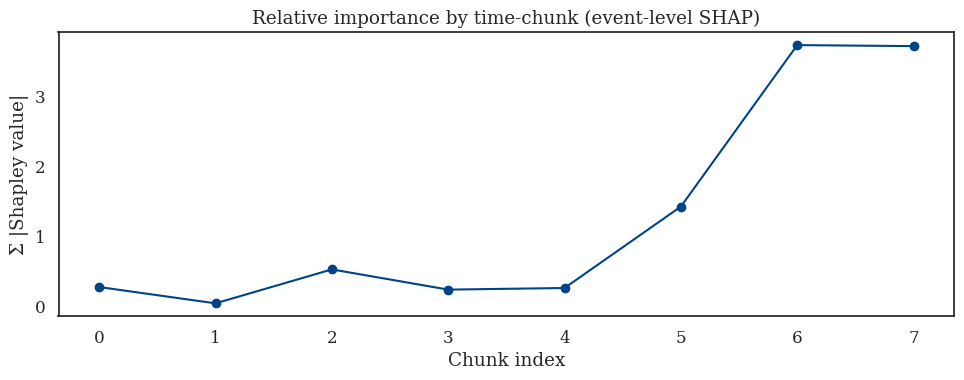

In [36]:
import evaluation.timeshap as tshap
importlib.reload(tshap)  
from evaluation.timeshap import plot_chunk_importance_by_events
#plot_chunk_importance_by_events(results_IMV_3, top_key="IMV_long")
#plot_chunk_importance_by_events(results_patch_short, top_key="patch_short")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_patch_short, top_key="patch_short", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="test_results/weather_int_144_10_PatchTST/attn_maps",results=results_patch_short, top_key="patch_short")
plot_chunk_importance_by_events_line(attn_dir="test_results/weather_int_144_10_PatchTST/attn_maps",results=results_patch_short, top_key="patch_short")

In [43]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)

from evaluation.timeshap import explain_with_chunks

# ─── 1) Define your patch-mid experiment ─────────────────────────────────────
experiments_patch_mid = [
    {
        "model":           model_patch_mid,
        "train_loader":    train_loader_patch_mid,
        "test_dataset":    dataset_test_patch_mid,
        "seq_len":         432,
        "out_prefix":      "patch_mid",
    },
]

# ─── 2) Shared SHAP hyper-parameters ─────────────────────────────────────────
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50,  "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run the chunked explanation ─────────────────────────────────────────
results_patch_mid = {}

for exp in experiments_patch_mid:
    tag = exp["out_prefix"]
    print(f"\n>>> Explaining {tag} …")
    results_patch_mid[tag] = explain_with_chunks(
        # core args
        model         = exp["model"],
        train_loader  = exp["train_loader"],
        test_dataset  = exp["test_dataset"],
        seq_len       = exp["seq_len"],

        # human-readable features
        feature_names = cols_weather_multi,

        # how to break the 432-step window into chunks
        chunk_thresh  = 20,
        out_prefix    = tag,

        # SHAP settings
        pruning_kwargs = pruning_kwargs,
        event_kwargs   = event_kwargs,
        feature_kwargs = feature_kwargs,

        # CPU/GPU selection
        device        = device,
    )



>>> Explaining patch_mid …
>>> Explaining chunk 1/22: [0:20] …
>>> Explaining chunk 2/22: [20:40] …
>>> Explaining chunk 3/22: [40:60] …
>>> Explaining chunk 4/22: [60:80] …
>>> Explaining chunk 5/22: [80:100] …
>>> Explaining chunk 6/22: [100:120] …
>>> Explaining chunk 7/22: [120:140] …
>>> Explaining chunk 8/22: [140:160] …
>>> Explaining chunk 9/22: [160:180] …
>>> Explaining chunk 10/22: [180:200] …
>>> Explaining chunk 11/22: [200:220] …
>>> Explaining chunk 12/22: [220:240] …
Unable to prune sequence.
>>> Explaining chunk 13/22: [240:260] …
Unable to prune sequence.
>>> Explaining chunk 14/22: [260:280] …
>>> Explaining chunk 15/22: [280:300] …
Unable to prune sequence.
>>> Explaining chunk 16/22: [300:320] …
Unable to prune sequence.
>>> Explaining chunk 17/22: [320:340] …
Unable to prune sequence.
>>> Explaining chunk 18/22: [340:360] …
Unable to prune sequence.
>>> Explaining chunk 19/22: [360:380] …
Unable to prune sequence.
>>> Explaining chunk 20/22: [380:400] …
>>> Expla

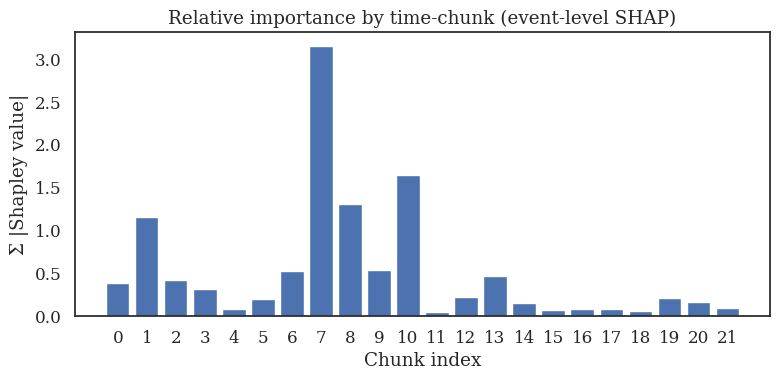

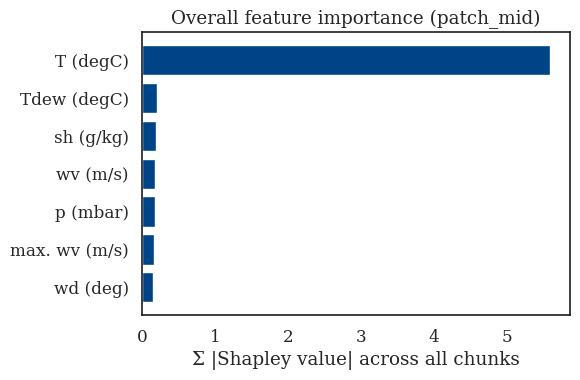

In [45]:
plot_chunk_importance_by_events(results_patch_mid, top_key="patch_mid")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_patch_mid, top_key="patch_mid", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="test_results/weather_int_432_72_PatchTST/attn_maps",results=results_patch_mid, top_key="patch_mid", feature_names=cols_weather_multi)

In [46]:
import importlib
import evaluation.timeshap as tshap      # bring in the module object
importlib.reload(tshap)                  # re-read it from disk
from evaluation.timeshap import explain_with_chunks

# ─── 1) Define your long-horizon experiment ────────────────────────────────
experiments_patch_long = [
    {
        "model":           model_patch_long,
        "train_loader":    train_loader_patch_long,
        "test_dataset":    dataset_test_patch_long,
        "seq_len":         576,
        "out_prefix":      "patch_long",
    },
]

# ─── 2) SHAP hyper-parameter grid (or single choice) ────────────────────────
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run explanations ────────────────────────────────────────────────────
results_patch_long = {}
for exp in experiments_patch_long:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_patch_long[exp['out_prefix']] = explain_with_chunks(
        # core args
        model         = exp["model"],
        train_loader  = exp["train_loader"],
        test_dataset  = exp["test_dataset"],
        seq_len       = exp["seq_len"],

        # human-readable feature names
        feature_names = cols_weather_multi,

        # chunking & output folder
        chunk_thresh  = 20,
        out_prefix    = exp["out_prefix"],

        # pruning-level SHAP
        pruning_kwargs = pruning_kwargs,

        # event-level SHAP
        event_kwargs   = event_kwargs,

        # feature-level SHAP
        feature_kwargs = feature_kwargs,

        # device (optional; defaults to cuda if available)
        device         = device
    )


>>> Explaining patch_long …
>>> Explaining chunk 1/29: [0:20] …
Unable to prune sequence.
>>> Explaining chunk 2/29: [20:40] …
Unable to prune sequence.
>>> Explaining chunk 3/29: [40:60] …
>>> Explaining chunk 4/29: [60:80] …
Unable to prune sequence.
>>> Explaining chunk 5/29: [80:100] …
Unable to prune sequence.
>>> Explaining chunk 6/29: [100:120] …
Unable to prune sequence.
>>> Explaining chunk 7/29: [120:140] …
>>> Explaining chunk 8/29: [140:160] …
>>> Explaining chunk 9/29: [160:180] …
>>> Explaining chunk 10/29: [180:200] …
Unable to prune sequence.
>>> Explaining chunk 11/29: [200:220] …
>>> Explaining chunk 12/29: [220:240] …
Unable to prune sequence.
>>> Explaining chunk 13/29: [240:260] …
Unable to prune sequence.
>>> Explaining chunk 14/29: [260:280] …
Unable to prune sequence.
>>> Explaining chunk 15/29: [280:300] …
>>> Explaining chunk 16/29: [300:320] …
>>> Explaining chunk 17/29: [320:340] …
Unable to prune sequence.
>>> Explaining chunk 18/29: [340:360] …
Unable to p

FileNotFoundError: [Errno 2] No such file or directory: 'test_results/weather_int_576_144PatchTST/attn_maps\\plots\\patch_long_feature_importance.png'

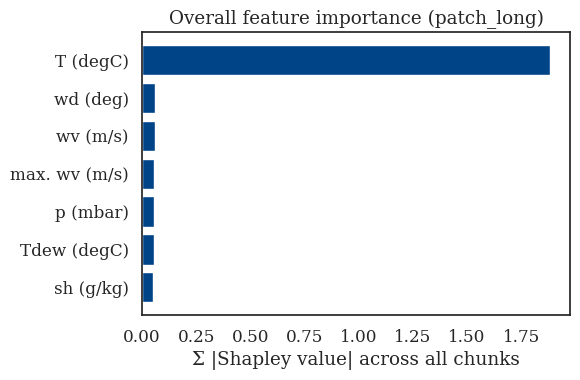

In [48]:
#plot_chunk_importance_by_events(results_patch_long, top_key="patch_long")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_patch_long, top_key="patch_long", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="test_results/weather_int_576_144PatchTST/attn_maps",results=results_patch_long, top_key="patch_long")

In [32]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)  
from evaluation.timeshap import explain_with_chunks

# ─── 1) Experiment definition ────────────────────────────────────────────────
experiments_patch_short_shared = [
    {
        "model":           model_patch_shared,
        "train_loader":    train_loader_patch_short,
        "test_dataset":    dataset_test,
        "seq_len":         144,
        "out_prefix":      "patch_short_shared",
    },
]

# ─── 2) Grid you want to try (for example) ──────────────────────────────────
# You can loop over any combination of tol / noise if you like,
# but here’s the simplest: one run with default hyper‐params.
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run `explain_with_chunks` on your patch_short model ────────────────
results_patch_short_shared = {}
for exp in experiments_patch_short_shared:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_patch_short_shared[exp['out_prefix']] = explain_with_chunks(
        # core args
        model        = exp["model"],
        train_loader = exp["train_loader"],
        test_dataset = exp["test_dataset"],
        seq_len      = exp["seq_len"],

        # human‐readable feature names
        feature_names = cols_weather_multi,

        # chunking & I/O
        chunk_thresh   = 20,
        out_prefix     = exp["out_prefix"],

        # pruning‐level SHAP
        pruning_kwargs = pruning_kwargs,

        # event‐level SHAP
        event_kwargs   = event_kwargs,

        # feature‐level SHAP
        feature_kwargs = feature_kwargs,

        # device (optional, defaults to cuda if available)
        device         = device
    )


>>> Explaining patch_short_shared …
>>> Explaining chunk 1/8: [0:20] …
>>> Explaining chunk 2/8: [20:40] …
>>> Explaining chunk 3/8: [40:60] …
>>> Explaining chunk 4/8: [60:80] …
>>> Explaining chunk 5/8: [80:100] …
Unable to prune sequence.
>>> Explaining chunk 6/8: [100:120] …
>>> Explaining chunk 7/8: [120:140] …
>>> Explaining chunk 8/8: [140:144] …


In [ ]:
#export_full_pruning_shap(
 #   results_patch_short_shared["patch_short_shared"],
  #  seq_len      = 144,
   # chunk_thresh = 20,
    #out_path     = "patch_short_shared_full_pruning_shap.npy")

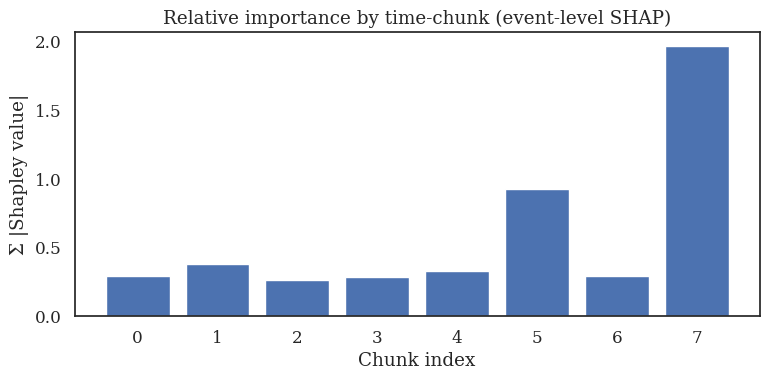

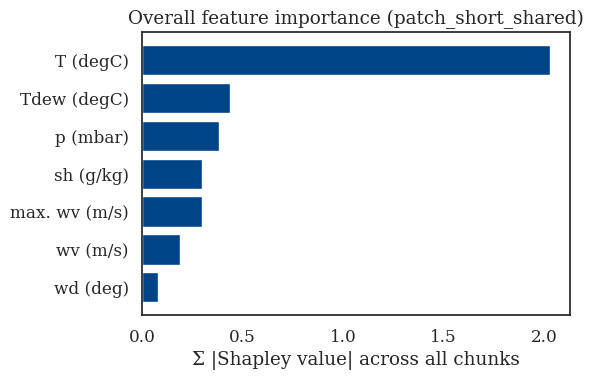

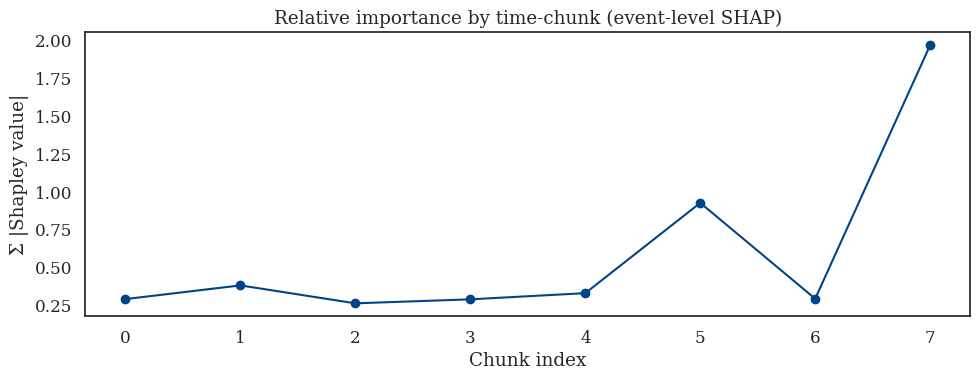

In [37]:
plot_chunk_importance_by_events(results_patch_short_shared, top_key="patch_short_shared")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_patch_long, top_key="patch_long", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="test_results/weather_int_144_10_PatchTST_shared/attn_maps",results=results_patch_short_shared, top_key="patch_short_shared")
plot_chunk_importance_by_events_line(attn_dir="test_results/weather_int_144_10_PatchTST_shared/attn_maps",results=results_patch_short_shared, top_key="patch_short_shared")

In [ ]:
import importlib
import evaluation.timeshap as tshap
importlib.reload(tshap)  
from evaluation.timeshap import explain_with_chunks



# ─── 1) Experiment definition ────────────────────────────────────────────────
experiments_patch_mid_shared = [
    {
        "model":           model_patch_mid_shared,
        "train_loader":    train_loader_patch_mid,
        "test_dataset":    dataset_test_patch_mid,
        "seq_len":         432,
        "out_prefix":      "patch_mid_shared",
    },
]

# ─── 2) Grid you want to try (for example) ──────────────────────────────────
# You can loop over any combination of tol / noise if you like,
# but here’s the simplest: one run with default hyper‐params.
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run `explain_with_chunks` on your patch_mid model ────────────────
results_patch_mid_shared = {}
for exp in experiments_patch_mid_shared:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_patch_mid_shared[exp['out_prefix']] = explain_with_chunks(
        # core args
        model        = exp["model"],
        train_loader = exp["train_loader"],
        test_dataset = exp["test_dataset"],
        seq_len      = exp["seq_len"],

        # human‐readable feature names
        feature_names = cols_weather_multi,

        # chunking & I/O
        chunk_thresh   = 20,
        out_prefix     = exp["out_prefix"],

        # pruning‐level SHAP
        pruning_kwargs = pruning_kwargs,

        # event‐level SHAP
        event_kwargs   = event_kwargs,

        # feature‐level SHAP
        feature_kwargs = feature_kwargs,

        # device (optional, defaults to cuda if available)
        device         = device
    )


In [ ]:
from evaluation.timeshap import plot_chunk_importance_by_events, plot_aggregated_feature_importance
plot_chunk_importance_by_events(results_patch_mid_shared, top_key="patch_mid_shared")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_patch_long, top_key="patch_long", chunk_id=2)

# Usage:
plot_aggregated_feature_importance(attn_dir="test_results/weather_int_432_72_PatchTST_shared/attn_maps",results=results_patch_mid_shared, top_key="patch_mid_shared")

In [ ]:
import importlib
import evaluation.timeshap as tshap      # bring in the module object
importlib.reload(tshap)                  # re-read it from disk
from evaluation.timeshap import explain_with_chunks

# ─── 1) Define your long-horizon experiment ────────────────────────────────
experiments_patch_long_shared = [
    {
        "model":           model_patch_long_shared,
        "train_loader":    train_loader_patch_long,
        "test_dataset":    dataset_test_patch_long,
        "seq_len":         576,
        "out_prefix":      "patch_long_shared",
    },
]

# ─── 2) SHAP hyper-parameter grid (or single choice) ────────────────────────
pruning_kwargs = { "tol": 0.05, "nsamples": 50 }
event_kwargs   = { "nsamples": 50, "noise_variance": 0.1 }
feature_kwargs = { "nsamples": 50 }

# ─── 3) Run explanations ────────────────────────────────────────────────────
results_patch_long_shared = {}
for exp in experiments_patch_long_shared:
    print(f">>> Explaining {exp['out_prefix']} …")
    results_patch_long_shared[exp['out_prefix']] = explain_with_chunks(
        # core args
        model         = exp["model"],
        train_loader  = exp["train_loader"],
        test_dataset  = exp["test_dataset"],
        seq_len       = exp["seq_len"],

        # human-readable feature names
        feature_names = cols_weather_multi,

        # chunking & output folder
        chunk_thresh  = 20,
        out_prefix    = exp["out_prefix"],

        # pruning-level SHAP
        pruning_kwargs = pruning_kwargs,

        # event-level SHAP
        event_kwargs   = event_kwargs,

        # feature-level SHAP
        feature_kwargs = feature_kwargs,

        # device (optional; defaults to cuda if available)
        device         = device
    )


In [ ]:
export_full_pruning_shap(
    results_patch_long_shared["patch_long_shared"],
    seq_len      = 576,
    chunk_thresh = 20,
    out_path     = "patch_long_shared_full_pruning_shap.npy"
)


In [ ]:
plot_chunk_importance_by_events(results_patch_long_shared, top_key="patch_long_shared")

# 2) Drill into chunk #2 and see which features within it were strongest:
#plot_feature_importance(results_patch_long, top_key="patch_long", chunk_id=26)

# Usage:
plot_aggregated_feature_importance(attn_dir="test_results/weather_int_576_144_PatchTST_shared/attn_maps",results=results_patch_long_shared, top_key="patch_long_shared")
plot_chunk_importance_by_events_line(attn_dir="test_results/weather_int_576_144_PatchTST_shared/attn_maps",results=results_patch_long_shared, top_key="patch_long_shared")

In [ ]:
#!pip freeze > requirements.txt


In [84]:
import os
import numpy as np
import pandas as pd
from typing import Callable
import torch
import matplotlib.pyplot as plt
from cycler import cycler


def preservation_check(
    ranking_df: pd.DataFrame,
    f_last: Callable[[np.ndarray], np.ndarray],
    x_window: np.ndarray,
    baseline_window: np.ndarray,
    feature_names: list[str],
    metric: Callable[[np.ndarray, np.ndarray], float]
) -> pd.DataFrame:
    """
    Runs a preservation check by progressively masking out the least-important features first.

    Args:
      ranking_df:      DataFrame with columns ['Feature', 'abs_shap'], sorted ascending by 'abs_shap'.
      f_last:          function mapping (N, win_len, n_feat) → (N,1) predictions.
      x_window:        original input window, shape (1, win_len, n_feat).
      baseline_window: baseline window, same shape as x_window.
      feature_names:   list of feature names, len=n_feat.
      metric:          function(y_orig, y_masked) → float (e.g., MSE).

    Returns:
      DataFrame with columns ['K', 'Masked_Features', 'Metric']
    """
    name2idx = {name: i for i, name in enumerate(feature_names)}
    ordered = ranking_df['Feature'].tolist()

    y_orig = f_last(x_window)
    records = []
    x_masked = x_window.copy()

    for k, feat in enumerate(ordered, start=1):
        idx = name2idx.get(feat)
        if idx is None:
            continue
        x_masked[..., idx] = baseline_window[..., idx]
        y_masked = f_last(x_masked)
        m = metric(y_orig, y_masked)
        records.append({'K': k, 'Masked_Features': ordered[:k].copy(), 'Metric': m})

    return pd.DataFrame(records)


def run_preservation_pipeline(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    results: dict,
    top_key: str,
    feature_names: list[str],
    start: int,
    end: int,
    metric: Callable[[np.ndarray, np.ndarray], float],
    background_size: int = 10,
    target_channel: int = -1,
    device: torch.device = None
) -> pd.DataFrame:
    """
    Full pipeline: aggregate SHAP, build baseline, slice window, define f_last, run preservation_check.

    Returns DataFrame from preservation_check.
    """
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.eval().to(device)

    # 1) aggregate
    all_feats = []
    for cid, info in results[top_key].items():
        df = info.get('feature')
        if df is None: continue
        tmp = df[['Feature', 'Shapley Value']].copy()
        tmp['abs_shap'] = tmp['Shapley Value'].abs()
        all_feats.append(tmp[['Feature', 'abs_shap']])
    agg = (pd.concat(all_feats, ignore_index=True)
             .groupby('Feature')['abs_shap'].sum()
             .reset_index().sort_values('abs_shap', ascending=True))

    # 2) baseline
    bg_list, cnt = [], 0
    for batch in train_loader:
        xb = batch[0] if isinstance(batch, (tuple, list)) else batch
        arr = xb.cpu().numpy() if torch.is_tensor(xb) else xb
        bg_list.append(arr); cnt += arr.shape[0]
        if cnt >= background_size: break
    baseline_full = np.vstack(bg_list)[:background_size].mean(axis=0, keepdims=True)

    # 3) window
    ds = test_loader.dataset if hasattr(test_loader, 'dataset') else test_loader
    x0 = ds[0][0]
    x_arr = x0.cpu().numpy() if torch.is_tensor(x0) else x0
    x_full = x_arr[None,...]
    x_window = x_full[:, start:end, :]
    baseline_window = baseline_full[:, start:end, :]

    # 4) f_last
    def f_last_windowed(X_sub: np.ndarray) -> np.ndarray:
        N, _, _ = X_sub.shape
        X_recon = np.repeat(baseline_full, N, axis=0)
        X_recon[:, start:end, :] = X_sub
        t = torch.from_numpy(X_recon).float().to(device)
        out = model(t)
        y_hat = out[0] if isinstance(out, tuple) else out
        return y_hat[:, -1, target_channel].detach().cpu().numpy().reshape(-1,1)

    # 5) preservation
    pres_df = preservation_check(
        ranking_df=agg,
        f_last=f_last_windowed,
        x_window=x_window,
        baseline_window=baseline_window,
        feature_names=feature_names,
        metric=metric
    )
    return pres_df


def plot_preservation_curve(
    pres_df: pd.DataFrame,
    feature_names: list[str],
    outfile: str,
    title: str = "Preservation Curve",
    xlabel: str = "# features preserved",
    ylabel: str = "Metric"
):
    """Plots preservation metric vs number (or percent) of features preserved."""
    total = len(feature_names)
    # Number preserved per step
    preserved_count = total - pres_df['K']

    plt.rcParams['axes.prop_cycle'] = cycler('color',
        ['#004488','#DDAA33','#BB5566','#66BBEE'])
    plt.rcParams.update({'font.family':'serif','font.size':12})
    plt.figure(figsize=(6,4))
    plt.plot(preserved_count, pres_df['Metric'], marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()

# ------------------- Example -------------------
# def mse_metric(y, yhat): return float(((y-yhat)**2).mean())
# pres_df = run_preservation_pipeline(
#     model, train_loader, test_loader,
#     results_patch_short, 'patch_short',
#     cols_weather_multi, start=0, end=144,
#     metric=mse_metric, background_size=10,
#     target_channel=-1, device=torch.device('cuda')
# )
# plot_preservation_curve(
#     pres_df, cols_weather_multi,
#     outfile='preservation_curve_patch_short_mse_count.png',
#     title='Preservation Curve (PatchTST short)',
#     xlabel='# features preserved', ylabel='MSE'
# )


In [86]:
import os
import numpy as np
import pandas as pd
from typing import Callable
import torch
import matplotlib.pyplot as plt
from cycler import cycler


def preservation_check_additive(
    ranking_df: pd.DataFrame,
    f_last: Callable[[np.ndarray], np.ndarray],
    x_window: np.ndarray,
    baseline_window: np.ndarray,
    feature_names: list[str],
    metric: Callable[[np.ndarray, np.ndarray], float]
) -> pd.DataFrame:
    """
    Additive preservation check: start from baseline (no features),
    then add features one-by-one in ascending importance order.

    Returns a DataFrame with columns:
      - K: number of features added
      - Added_Features: list of features included so far
      - Metric: performance metric at this step
    """
    name2idx = {name: i for i, name in enumerate(feature_names)}
    ordered = ranking_df['Feature'].tolist()

    # Step 0: baseline prediction (no features)
    x_build = baseline_window.copy()
    y_base = f_last(x_build)
    records = [{'K': 0, 'Added_Features': [], 'Metric': metric(y_base, y_base)}]

    # Add features progressively
    for k, feat in enumerate(ordered, start=1):
        idx = name2idx.get(feat)
        if idx is None:
            continue
        # inject the k-th feature
        x_build[..., idx] = x_window[..., idx]
        y_hat = f_last(x_build)
        m = metric(y_base, y_hat)
        records.append({'K': k, 'Added_Features': ordered[:k].copy(), 'Metric': m})

    return pd.DataFrame(records)


def run_additive_preservation_pipeline(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    results: dict,
    top_key: str,
    feature_names: list[str],
    start: int,
    end: int,
    metric: Callable[[np.ndarray, np.ndarray], float],
    background_size: int = 10,
    target_channel: int = -1,
    device: torch.device = None
) -> pd.DataFrame:
    """
    Full additive pipeline: aggregate SHAP importances, build baseline,
    slice test window, define f_last, then run additive preservation check.
    """
    # Device and model setup
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.eval().to(device)

    # 1) aggregate |Shapley| importances (ascending)
    all_feats = []
    for cid, info in results[top_key].items():
        df = info.get('feature')
        if df is None:
            continue
        tmp = df[['Feature', 'Shapley Value']].copy()
        tmp['abs_shap'] = tmp['Shapley Value'].abs()
        all_feats.append(tmp[['Feature', 'abs_shap']])
    agg = (
        pd.concat(all_feats, ignore_index=True)
          .groupby('Feature')['abs_shap'].sum()
          .reset_index()
          .sort_values('abs_shap', ascending=True)
    )

    # 2) build baseline_full
    bg_list, cnt = [], 0
    for batch in train_loader:
        xb = batch[0] if isinstance(batch, (tuple, list)) else batch
        arr = xb.cpu().numpy() if torch.is_tensor(xb) else xb
        bg_list.append(arr)
        cnt += arr.shape[0]
        if cnt >= background_size:
            break
    baseline_full = np.vstack(bg_list)[:background_size].mean(axis=0, keepdims=True)

    # 3) extract window from single test example
    ds = test_loader.dataset if hasattr(test_loader, 'dataset') else test_loader
    x0 = ds[0][0]
    x_arr = x0.cpu().numpy() if torch.is_tensor(x0) else x0
    x_full = x_arr[None, ...]
    x_window = x_full[:, start:end, :]
    baseline_window = baseline_full[:, start:end, :]

    # 4) define f_last_windowed
    def f_last_windowed(X_sub: np.ndarray) -> np.ndarray:
        N, _, _ = X_sub.shape
        X_recon = np.repeat(baseline_full, N, axis=0)
        X_recon[:, start:end, :] = X_sub
        t = torch.from_numpy(X_recon).float().to(device)
        out = model(t)
        y_hat = out[0] if isinstance(out, tuple) else out
        return y_hat[:, -1, target_channel].detach().cpu().numpy().reshape(-1,1)

    # 5) run additive check
    return preservation_check_additive(
        ranking_df=agg,
        f_last=f_last_windowed,
        x_window=x_window,
        baseline_window=baseline_window,
        feature_names=feature_names,
        metric=metric
    )


def plot_additive_preservation(
    pres_df: pd.DataFrame,
    feature_names: list[str],
    outfile: str,
    title: str = "Additive Preservation Curve",
    xlabel: str = "# features added",
    ylabel: str = "Metric"
):
    """
    Plots the Metric against the number of features added.
    """
    plt.rcParams['axes.prop_cycle'] = cycler('color',
        ['#004488','#DDAA33','#BB5566','#66BBEE'])
    plt.rcParams.update({'font.family':'serif','font.size':12})
    plt.figure(figsize=(6,4))
    plt.plot(pres_df['K'], pres_df['Metric'], marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()

# ------------------- Example -------------------
#
# def mse_metric(y, yhat): return float(((y - yhat)**2).mean())
# pres_df = run_additive_preservation_pipeline(
#     model, train_loader, test_loader,
#     results_patch_short, 'patch_short',
#     cols_weather_multi, start=0, end=144,
#     metric=mse_metric, background_size=10,
#     target_channel=-1, device=torch.device('cuda')
# )
# plot_additive_preservation(
#     pres_df, cols_weather_multi,
#     outfile='additive_preservation_patch_short.png',
#     title='Additive Preservation (PatchTST short)',
#     xlabel='# features added', ylabel='MSE'
# )


In [91]:
def mse_metric(y, yhat): return float(((y-yhat)**2).mean())
# compute full-feature prediction once
# = f_last(x_window)

def mse_to_full(y_full, y_hat):
    # y_hat is prediction after adding K features
    return float(np.mean((y_full - y_hat)**2))

# then pass mse_to_full into run_additive_preservation_pipeline

pres_df = run_additive_preservation_pipeline(
     model=model_patch,
     train_loader=train_loader_patch_short,
     test_loader=test_loader_patch,
     results=results_patch_short,
     top_key='patch_short',
     feature_names=cols_weather_multi,
     start=0,
     end=144,
     metric=mse_metric,
     background_size=10,
     target_channel=-1,
     device=torch.device('cpu')
 )
print(pres_df)

   K                                     Added_Features    Metric
0  0                                                 []  0.000000
1  1                                         [p (mbar)]  0.000000
2  2                          [p (mbar), max. wv (m/s)]  0.000000
3  3               [p (mbar), max. wv (m/s), sh (g/kg)]  0.000000
4  4  [p (mbar), max. wv (m/s), sh (g/kg), Tdew (degC)]  0.000000
5  5  [p (mbar), max. wv (m/s), sh (g/kg), Tdew (deg...  0.000000
6  6  [p (mbar), max. wv (m/s), sh (g/kg), Tdew (deg...  0.000000
7  7  [p (mbar), max. wv (m/s), sh (g/kg), Tdew (deg...  2.087002


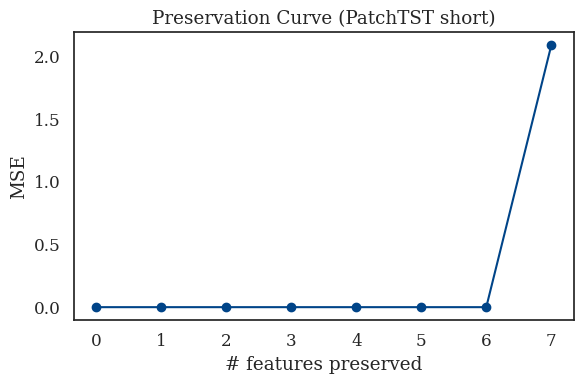

In [92]:
plot_additive_preservation(
     pres_df, cols_weather_multi,
     outfile='preservation_curve_patch_short_mse_count.png',
     title='Preservation Curve (PatchTST short)',
     xlabel='# features preserved', ylabel='MSE'
 )

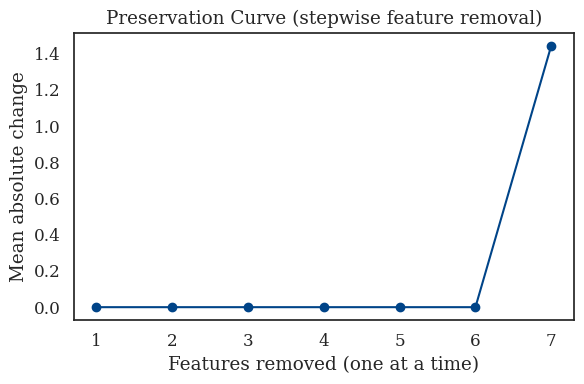

In [72]:
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.pyplot as plt
from cycler import cycler

# 1) Same look & feel
plt.rcParams['axes.prop_cycle'] = cycler('color',
        ['#004488','#DDAA33','#BB5566','#66BBEE'])
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
})
plt.figure(figsize=(6,4))

# 2) X = K (step 1, 2, 3, …), Y = preservation metric
plt.plot(pres_df['K'], pres_df['Metric'], marker='o')

# 3) (Optional) If you want tick‐labels to show which feature was removed at each step:
# plt.xticks(
#     pres_df['K'],
#     [feat_list[0] for feat_list in pres_df['Masked_Features']],
#     rotation=45, ha='right'
# )

plt.xlabel("Features removed (one at a time)")
plt.ylabel("Mean absolute change")
plt.title("Preservation Curve (stepwise feature removal)")
plt.grid(False)
plt.tight_layout()

plt.savefig('preservation_curve_patch_short', dpi=300)
plt.show()



   K                                     Added_Features    Metric
0  0                                                 []  0.000000
1  1                                         [wd (deg)]  0.000006
2  2                               [wd (deg), wv (m/s)]  0.000743
3  3                [wd (deg), wv (m/s), max. wv (m/s)]  0.003342
4  4     [wd (deg), wv (m/s), max. wv (m/s), sh (g/kg)]  0.004982
5  5  [wd (deg), wv (m/s), max. wv (m/s), sh (g/kg),...  0.006608
6  6  [wd (deg), wv (m/s), max. wv (m/s), sh (g/kg),...  0.010391
7  7  [wd (deg), wv (m/s), max. wv (m/s), sh (g/kg),...  2.071084


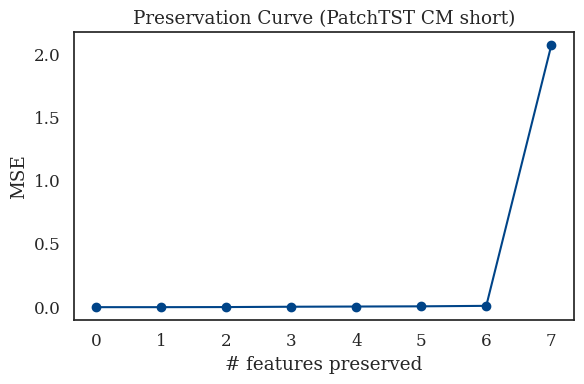

In [95]:

# ------------------- Example call -------------------
pres_df_shared = run_additive_preservation_pipeline(
     model=model_patch_shared,
     train_loader=train_loader_patch_short,
     test_loader=test_loader_patch,
     results=results_patch_short_shared,
     top_key='patch_short_shared',
     feature_names=cols_weather_multi,
     start=0,
     end=144,
     metric=mse_metric,
     background_size=10,
     target_channel=-1,
     device=torch.device('cpu')
 )
print(pres_df_shared)
# 1) Same look & feel
plot_additive_preservation(
     pres_df_shared, cols_weather_multi,
     outfile='preservation_curve_patch_short_shared_mse_count.png',
     title='Preservation Curve (PatchTST CM short)',
     xlabel='# features preserved', ylabel='MSE'
 )

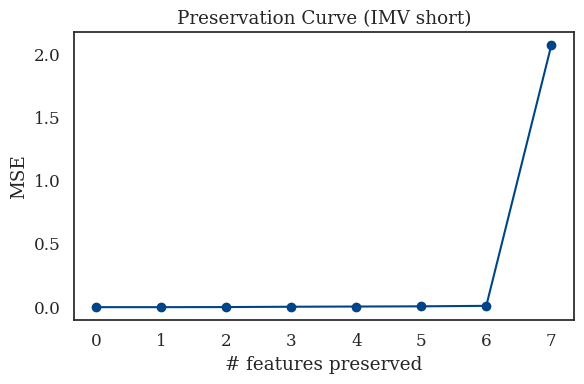

In [97]:

# ------------------- Example call -------------------
pres_df_IMV = run_additive_preservation_pipeline(
     model=model_IMV,
     train_loader=train_loader_IMV_short,
     test_loader=test_loader_IMV,
     results=results_IMV_1,
     top_key='IMV_short',
     feature_names=cols_weather_multi,
     start=0,
     end=144,
     metric=mse_metric,
     background_size=10,
     target_channel=-1,
     device=torch.device('cpu')
 )
# 1) Same look & feel
plot_additive_preservation(
     pres_df_shared, cols_weather_multi,
     outfile='preservation_curve_IMV_short_mse_count.png',
     title='Preservation Curve (IMV short)',
     xlabel='# features preserved', ylabel='MSE'
 )